In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import DeepMIMOv3 

# ==========================================
# 1. SCENARIO CONFIG
# ==========================================
SCENARIOS = {
    'city_6_miami':       {'n_rows': 199, 'n_ant': 16,  'n_sub': 32},
    'city_7_sandiego':    {'n_rows': 71,  'n_ant': 16,  'n_sub': 64},
    'city_11_santaclara': {'n_rows': 117, 'n_ant': 32,  'n_sub': 32},
    'city_12_fortworth':  {'n_rows': 214, 'n_ant': 32,  'n_sub': 64},
    'city_15_indianapolis':{'n_rows': 200, 'n_ant': 64,  'n_sub': 32},
    'city_18_denver':     {'n_rows': 212, 'n_ant': 128, 'n_sub': 32},
    'city_19_oklahoma':   {'n_rows': 204, 'n_ant': 128, 'n_sub': 64},
}

# Define which scenarios are for TRAINING
TRAIN_SCENARIOS = [
    'city_6_miami', 'city_7_sandiego', 'city_11_santaclara', 
    'city_15_indianapolis', 'city_12_fortworth'
]

# Define which are for TESTING (Unseen shapes/cities)
TEST_SCENARIOS = ['city_18_denver', 'city_19_oklahoma']

# Define the "Canvas Size" (Max dimensions across all datasets)
MAX_ANT = 128
MAX_SUB = 64

# ==========================================
# 2. PADDED DATA GENERATOR
# ==========================================
class UnifiedChannelGenerator:
    def __init__(self, scenario_name, config, bs_idx=1):
        self.params = DeepMIMOv3.default_params()
        self.params['dataset_folder'] = './scenarios'
        self.params['scenario'] = scenario_name.split("_v")[0]
        self.params['active_BS'] = np.array([bs_idx])
        self.params['user_rows'] = np.arange(config['n_rows'])
        self.params['bs_antenna']['shape'] = np.array([config['n_ant'], 1]) 
        self.params['ue_antenna']['shape'] = np.array([1, 1])
        self.params['OFDM']['subcarriers'] = config['n_sub']
        self.params['OFDM']['selected_subcarriers'] = np.arange(config['n_sub'])
        self.params['OFDM']['bandwidth'] = 0.02
        
        self.current_shape = (config['n_ant'], config['n_sub'])

    def get_data(self):
        print(f"  > Generating {self.params['scenario']} {self.current_shape}...")
        try:
            deepmimo_data = DeepMIMOv3.generate_data(self.params)
            los = deepmimo_data[0]['user']['LoS']
            valid = np.where(los != -1)[0]
            
            raw_chs = deepmimo_data[0]['user']['channel'][valid]
            if raw_chs.ndim == 4: raw_chs = raw_chs.squeeze()
            
            # (K, 2, Ant, Sub)
            chs_stacked = np.stack([raw_chs.real, raw_chs.imag], axis=1)
            
            # --- PADDING LOGIC ---
            # Create canvas of zeros (K, 2, MAX_ANT, MAX_SUB)
            K, _, cur_ant, cur_sub = chs_stacked.shape
            canvas = np.zeros((K, 2, MAX_ANT, MAX_SUB), dtype=np.float32)
            
            # Paste data into top-left corner
            canvas[:, :, :cur_ant, :cur_sub] = chs_stacked
            
            # Create mask to know which part is real data (for loss calculation later?)
            # For now, we just trust the AE to learn zero=zero.
            
            return canvas, los[valid]
        except Exception as e:
            print(f"    Error: {e}. Using Dummy.")
            return np.zeros((100, 2, MAX_ANT, MAX_SUB), dtype=np.float32), np.zeros(100)



In [23]:
# ==========================================
# 3. UNIVERSAL AUTOENCODER
# ==========================================
class UniversalAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        
        # Max Input: (2, 128, 64)
        
        self.encoder = nn.Sequential(
            # (2, 128, 64)
            nn.Conv2d(2, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # -> (32, 64, 32)
            
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # -> (64, 32, 16)
            
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), # -> (128, 16, 8)
            
            nn.Flatten()
        )
        
        # 128 * 16 * 8 = 16384
        self.flat_size = 128 * 16 * 8
        self.fc_enc = nn.Linear(self.flat_size, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flat_size)
        
        self.decoder = nn.Sequential(
            # Input: (128, 16, 8)
            nn.ConvTranspose2d(128, 64, 2, stride=2), # -> (64, 32, 16)
            nn.BatchNorm2d(64), nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 2, stride=2),  # -> (32, 64, 32)
            nn.BatchNorm2d(32), nn.ReLU(),
            
            nn.ConvTranspose2d(32, 2, 2, stride=2),   # -> (2, 128, 64)
            # No activation
        )

    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        rec = self.fc_dec(z).view(-1, 128, 16, 8)
        return self.decoder(rec), z



In [24]:
def nmse_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    Calculates Normalized Mean Squared Error (NMSE) per sample.
    """
    y_pred_flat = y_pred.view(y_pred.size(0), -1)
    y_true_flat = y_true.view(y_true.size(0), -1)

    mse = torch.sum((y_true_flat - y_pred_flat)**2, dim=1)
    normalization = torch.sum(y_true_flat**2, dim=1)
    
    # Epsilon for stability
    normalization = torch.clamp(normalization, min=1e-10)
    
    # Return mean NMSE over the batch
    return torch.mean(mse / normalization)

In [25]:
# ==========================================
# 4. EXECUTION LOOP
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- A. BUILD TRAINING DATASET ---
print(f">>> 1. Building Training Set (Max Size: {MAX_ANT}x{MAX_SUB})...")
train_tensors_x = []
train_tensors_y = []

for sc_name in TRAIN_SCENARIOS:
    gen = UnifiedChannelGenerator(sc_name, SCENARIOS[sc_name])
    x, y = gen.get_data()
    
    # Normalize (Global normalization is tricky, doing per-dataset approx)
    x = (x - np.mean(x)) / (np.std(x) + 1e-9)
    
    train_tensors_x.append(torch.tensor(x, dtype=torch.float32))
    train_tensors_y.append(torch.tensor(y, dtype=torch.long))
    
# Concatenate all training data
X_train = torch.cat(train_tensors_x)
Y_train = torch.cat(train_tensors_y)

train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
print(f"    Total Training Samples: {len(train_ds)}")

# --- B. TRAIN MODEL ---
print("\n>>> 2. Training Universal Autoencoder with NMSE...")
ae = UniversalAutoencoder(latent_dim=64).to(DEVICE)
opt = optim.Adam(ae.parameters(), lr=1e-4)

for epoch in range(400): # Increased slightly to allow NMSE convergence
    ae.train()
    loss_sum = 0
    for x_batch, _ in tqdm(train_loader, desc=f"Ep {epoch+1}"):
        x_batch = x_batch.to(DEVICE)
        opt.zero_grad()
        rec, _ = ae(x_batch)
        
        # CHANGED: Use custom NMSE loss
        loss = nmse_loss(rec, x_batch)
        
        loss.backward()
        opt.step()
        loss_sum += loss.item()
        
    avg_nmse = loss_sum / len(train_loader)
    nmse_db = 10 * np.log10(avg_nmse)
    print(f"    NMSE: {avg_nmse:.5f} ({nmse_db:.2f} dB)")

# --- C. TEST ON UNSEEN SCENARIOS ---
print("\n>>> 3. Testing on UNSEEN Scenarios...")

for sc_name in TEST_SCENARIOS:
    print(f"\n--- Testing {sc_name} (Unseen Shape) ---")
    cfg = SCENARIOS[sc_name]
    gen = UnifiedChannelGenerator(sc_name, cfg)
    x_np, _ = gen.get_data()
    
    # Normalize
    x_np = (x_np - np.mean(x_np)) / (np.std(x_np) + 1e-9)
    x_test = torch.tensor(x_np, dtype=torch.float32).to(DEVICE)
    
    # Inference
    ae.eval()
    with torch.no_grad():
        rec_test, latent = ae(x_test)
        
        # CHANGED: Calculate Test NMSE
        test_nmse = nmse_loss(rec_test, x_test).item()
        test_nmse_db = 10 * np.log10(test_nmse)
    
    print(f"    Reconstruction NMSE: {test_nmse:.5f} ({test_nmse_db:.2f} dB)")
    
    # VISUALIZATION
    # We need to un-pad to see if the model respected the active region
    real_ant, real_sub = cfg['n_ant'], cfg['n_sub']
    
    orig_crop = x_test[0, 0, :real_ant, :real_sub].cpu().numpy()
    rec_crop  = rec_test[0, 0, :real_ant, :real_sub].cpu().numpy()
    
    # Also check the padded region (should be zero)
    # Note: If max size is reached, slicing [real_ant:] might be empty, handle safely
    if real_ant < MAX_ANT or real_sub < MAX_SUB:
        pad_region = rec_test[0, 0, real_ant:, real_sub:].cpu().numpy()
    else:
        pad_region = np.zeros((1,1)) # Dummy if full size
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(orig_crop, aspect='auto'); plt.title(f"Original {real_ant}x{real_sub}")
    plt.subplot(1, 3, 2); plt.imshow(rec_crop, aspect='auto'); plt.title("Reconstructed Active")
    plt.subplot(1, 3, 3); plt.imshow(rec_test[0,0].cpu().numpy(), aspect='auto'); plt.title("Full Canvas (Check Padding)")
    plt.show()

>>> 1. Building Training Set (Max Size: 128x64)...
  > Generating city_6_miami (16, 32)...

Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 42984/42984 [00:02<00:00, 18604.28it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 506.74it/s]


: 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import DeepMIMOv3 

# ==========================================
# 1. THE COMPRESSION MODEL (Adaptive)
# ==========================================
class ChannelAutoencoder(nn.Module):
    def __init__(self, num_antennas=16, num_subcarriers=32, latent_dim=16):
        super().__init__()
        
        # --- ENCODER (Compression) ---
        # Input: (Batch, 2, M, SC) -> Real/Imag are channels
        self.encoder = nn.Sequential(
            # Layer 1: Capture local features
            # Input: (2, 16, 32)
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), # -> (16, 8, 16)
            
            # Layer 2: Capture global structure
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # -> (32, 4, 8)
            
            # Flatten
            nn.Flatten()
        )
        
        # Calculate flattened size dynamically
        # After 2 pooling layers, dimensions are divided by 4
        h_dim = num_antennas // 4
        w_dim = num_subcarriers // 4
        self.flattened_size = 32 * h_dim * w_dim
        self.decoder_input_shape = (32, h_dim, w_dim)
        
        print(f"Model Init: Input ({num_antennas}x{num_subcarriers}) -> Flattened Size: {self.flattened_size} -> Latent: {latent_dim}")
        
        # The Bottleneck
        self.fc_enc = nn.Linear(self.flattened_size, latent_dim)
        
        # --- DECODER (Reconstruction) ---
        self.fc_dec = nn.Linear(latent_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            # Layer 1: Upsample
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Layer 2: Restore original size
            nn.ConvTranspose2d(16, 2, kernel_size=2, stride=2),
            # No activation at end (Channels can be negative)
        )

    def forward(self, x):
        # x: (Batch, 2, M, SC)
        
        # Encode
        features = self.encoder(x)
        latent_code = self.fc_enc(features) # This is the compressed info
        
        # Decode
        x_rec = self.fc_dec(latent_code)
        x_rec = x_rec.view(-1, *self.decoder_input_shape)
        reconstruction = self.decoder(x_rec)
        
        return reconstruction, latent_code

# ==========================================
# 2. DOWNSTREAM TASK (The Judge)
# ==========================================
class LatentClassifier(nn.Module):
    """
    Tries to predict LoS/NLoS using ONLY the compressed latent code.
    """
    def __init__(self, latent_dim, num_classes=2):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        return self.head(x)

# ==========================================
# 3. DATA GENERATION (Adjusted Parameters)
# ==========================================
class SimpleChannelGenerator:
    """ Wrapper for DeepMIMO to get (Batch, 2, M, SC) data """
    def __init__(self, scenario_name='city_6_miami', bs_idx=1):
        self.params = DeepMIMOv3.default_params()
        self.params['dataset_folder'] = './scenarios'
        self.params['scenario'] = scenario_name.split("_v")[0]
        self.params['active_BS'] = np.array([bs_idx])
        
        # --- UPDATED PARAMETERS ---
        self.params['user_rows'] = np.arange(199) 
        self.params['bs_antenna']['shape'] = np.array([16, 1]) 
        self.params['ue_antenna']['shape'] = np.array([1, 1])
        
        # 32 Subcarriers configuration
        self.params['OFDM']['subcarriers'] = 32 
        self.params['OFDM']['selected_subcarriers'] = np.arange(32)
        self.params['OFDM']['bandwidth'] = 30e3 * 32 / 1e9 # 0.00096 GHz

    def get_data(self):
        print(f"Generating data for {self.params['scenario']} (32 Subcarriers)...")
        try:
            deepmimo_data = DeepMIMOv3.generate_data(self.params)
            los = deepmimo_data[0]['user']['LoS']
            valid = np.where(los != -1)[0]
            
            # Extract raw channels
            # Shape might be (K, BS_Ant, UE_Ant, Subcarriers) -> (K, 16, 1, 32)
            raw_chs = deepmimo_data[0]['user']['channel'][valid]
            
            # Fix dimensions: Squeeze UE antenna dimension
            if raw_chs.ndim == 4:
                chs_complex = raw_chs.squeeze() # (K, 16, 32)
            else:
                chs_complex = raw_chs
            
            labels = los[valid]
            
            # Convert to (K, 2, M, SC) for CNN
            # Channel 0 = Real, Channel 1 = Imag
            chs_real = chs_complex.real
            chs_imag = chs_complex.imag
            
            # Stack: (K, 2, M, SC)
            chs_stacked = np.stack([chs_real, chs_imag], axis=1)
            
            print(f"Data Generated. Shape: {chs_stacked.shape}")
            return chs_stacked, labels
        except Exception as e:
            print(f"⚠️ DeepMIMO Error: {e}")
            print("Using DUMMY data for testing logic.")
            return np.random.randn(1000, 2, 16, 32), np.random.randint(0, 2, 1000)



In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration
NUM_ANTENNAS = 16
NUM_SUBCARRIERS = 32
LATENT_DIM = 64  

# --- A. PREPARE DATA ---
print(">>> 1. Generating Data...")
gen = SimpleChannelGenerator()
X_np, y_np = gen.get_data()

# Normalize data (Zero mean, Unit variance)
# This is critical for Autoencoders to converge
mean = X_np.mean()
std = X_np.std()
X_norm = (X_np - mean) / (std + 1e-9)

X = torch.tensor(X_norm, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

# Split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)



>>> 1. Generating Data...
Generating data for city_6_miami (32 Subcarriers)...

Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 42984/42984 [00:02<00:00, 17748.12it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 489.59it/s]


Data Generated. Shape: (10441, 2, 16, 32)


In [15]:
# --- B. TRAIN AUTOENCODER ---
print(f"\n>>> 2. Training Autoencoder...")
print(f"    Compression Ratio: {NUM_ANTENNAS*NUM_SUBCARRIERS*2} -> {LATENT_DIM} floats")

ae = ChannelAutoencoder(num_antennas=NUM_ANTENNAS, 
                        num_subcarriers=NUM_SUBCARRIERS, 
                        latent_dim=LATENT_DIM).to(DEVICE)

optimizer_ae = optim.Adam(ae.parameters(), lr=1e-4)
criterion_ae = nn.MSELoss()

ae_losses = []

for epoch in range(500):
    ae.train()
    epoch_loss = 0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(DEVICE)
        
        optimizer_ae.zero_grad()
        rec, _ = ae(batch_x)
        loss = criterion_ae(rec, batch_x)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    ae_losses.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"   Epoch {epoch+1}: Recon Loss {avg_loss:.4f}")
        



>>> 2. Training Autoencoder...
    Compression Ratio: 1024 -> 64 floats
Model Init: Input (16x32) -> Flattened Size: 1024 -> Latent: 64
   Epoch 5: Recon Loss 0.9993
   Epoch 10: Recon Loss 0.8038
   Epoch 15: Recon Loss 0.5968
   Epoch 20: Recon Loss 0.4314
   Epoch 25: Recon Loss 0.3274
   Epoch 30: Recon Loss 0.2570
   Epoch 35: Recon Loss 0.2055
   Epoch 40: Recon Loss 0.1619
   Epoch 45: Recon Loss 0.1211
   Epoch 50: Recon Loss 0.1109
   Epoch 55: Recon Loss 0.1073
   Epoch 60: Recon Loss 0.0882
   Epoch 65: Recon Loss 0.0862
   Epoch 70: Recon Loss 0.0863
   Epoch 75: Recon Loss 0.0815
   Epoch 80: Recon Loss 0.0727
   Epoch 85: Recon Loss 0.0716
   Epoch 90: Recon Loss 0.0730
   Epoch 95: Recon Loss 0.0630
   Epoch 100: Recon Loss 0.0688
   Epoch 105: Recon Loss 0.0644
   Epoch 110: Recon Loss 0.0692
   Epoch 115: Recon Loss 0.0609
   Epoch 120: Recon Loss 0.0625
   Epoch 125: Recon Loss 0.0569
   Epoch 130: Recon Loss 0.0585
   Epoch 135: Recon Loss 0.0572
   Epoch 140: Recon


>>> 3. Training Downstream Classifier (LoS/NLoS)...
   Epoch 5: Accuracy 0.9415
   Epoch 10: Accuracy 0.9594
   Epoch 15: Accuracy 0.9626
   Epoch 20: Accuracy 0.9643
   Epoch 25: Accuracy 0.9662
   Epoch 30: Accuracy 0.9670
   Epoch 35: Accuracy 0.9674
   Epoch 40: Accuracy 0.9685
   Epoch 45: Accuracy 0.9692
   Epoch 50: Accuracy 0.9703

>>> 4. Visualizing Results...


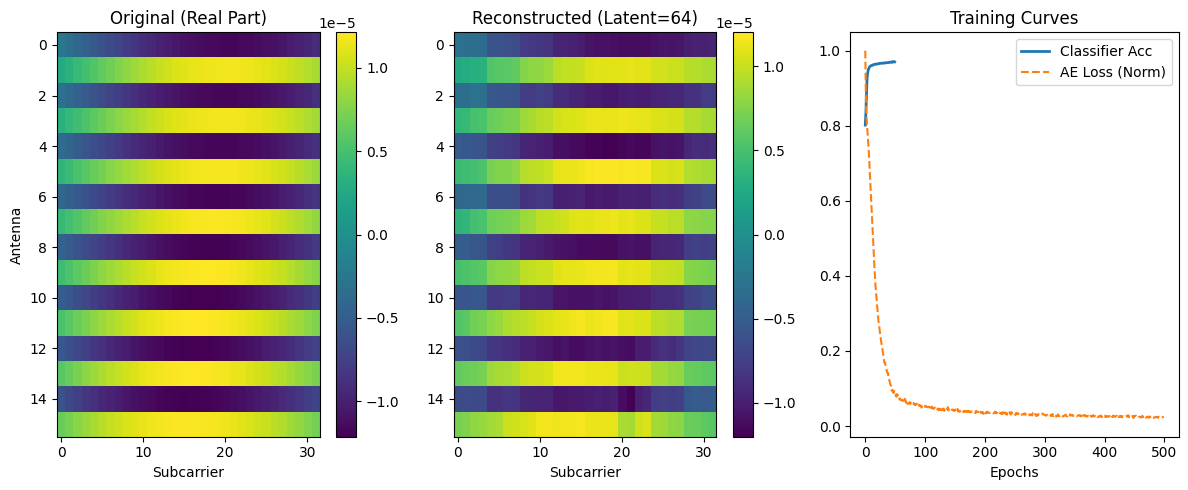


Final Classification Accuracy: 97.03%


In [16]:
# --- C. TRAIN DOWNSTREAM TASK (Using Frozen Latent) ---
print("\n>>> 3. Training Downstream Classifier (LoS/NLoS)...")

# Freeze AE
ae.eval() 
for p in ae.parameters(): p.requires_grad = False

classifier = LatentClassifier(latent_dim=LATENT_DIM).to(DEVICE)
optimizer_clf = optim.Adam(classifier.parameters(), lr=1e-4)
criterion_clf = nn.CrossEntropyLoss()

clf_accs = []

for epoch in range(50):
    classifier.train()
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        
        # Get Compressed Representation
        with torch.no_grad():
            _, latent = ae(batch_x)
        
        # Predict
        optimizer_clf.zero_grad()
        logits = classifier(latent)
        loss = criterion_clf(logits, batch_y)
        loss.backward()
        optimizer_clf.step()
        
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
        
    acc = correct / total
    clf_accs.append(acc)
    if (epoch+1) % 5 == 0:
        print(f"   Epoch {epoch+1}: Accuracy {acc:.4f}")

# --- D. VISUALIZATION ---
print("\n>>> 4. Visualizing Results...")

# 1. Check Reconstruction Quality
sample_x = test_ds[0][0].unsqueeze(0).to(DEVICE) # (1, 2, M, SC)
with torch.no_grad():
    rec_x, _ = ae(sample_x)

# Un-normalize for plotting
orig_real = sample_x[0, 0].cpu().numpy() * std + mean
recon_real = rec_x[0, 0].cpu().numpy() * std + mean

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_real, aspect='auto', cmap='viridis')
plt.title("Original (Real Part)")
plt.xlabel("Subcarrier")
plt.ylabel("Antenna")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(recon_real, aspect='auto', cmap='viridis')
plt.title(f"Reconstructed (Latent={LATENT_DIM})")
plt.xlabel("Subcarrier")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.plot(clf_accs, label='Classifier Acc', linewidth=2)
plt.plot(np.array(ae_losses)/max(ae_losses), label='AE Loss (Norm)', linestyle='--')
plt.title("Training Curves")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Classification Accuracy: {clf_accs[-1]*100:.2f}%")